In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.data[0:100] # 1-е отличие: маленький тренировочный датасет, легко зазубрить, вместо того 
y_train = MNIST_train.targets[0:100] # чтобы учиться обобщать
X_test = MNIST_test.data[0:200]
y_test = MNIST_test.targets[0:200]

In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape

(torch.Size([100, 28, 28]), torch.Size([200, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([100]), torch.Size([200]))

In [8]:
#import matplotlib.pyplot as plt
#plt.imshow(X_train[10, :, :])
#plt.show()
#print(y_train[10])

In [9]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [10]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 5*n_hidden_neurons)# 2-й шаг: слишком сложная сеть для такого 
        self.ac1 = torch.nn.Sigmoid()
        self.fc12 = torch.nn.Linear(5*n_hidden_neurons, 1*n_hidden_neurons)# наглядного датасета
        self.ac12 = torch.nn.Sigmoid()
        self.fc22 = torch.nn.Linear(1*n_hidden_neurons, 1*n_hidden_neurons)#
        self.ac22 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(1*n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc12(x)
        x = self.ac12(x)
        x = self.fc22(x)
        x = self.ac22(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(300)
#                28*28; 1500; 300; 300; 10

In [11]:
torch.cuda.is_available()

True

In [12]:
!nvidia-smi

Sun May 17 22:55:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 750 Ti  On   | 00000000:01:00.0 Off |                  N/A |
| 14%   36C    P8     1W /  38W |    655MiB /  1999MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
#list(mnist_net.parameters())

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=7.5e-4) # 1.0e-3) # легкое изменение. ухудшать LR цели нет.

In [15]:
batch_size = 1 # переобучение достигается легче, 
               # когда на малом кол-ве данных умная сеть обучается на индивидуальных экземплярах.
               # - уменьшаем ее шансы учиться обобщать.
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

for epoch in range(200): # 200 эпох достаточно чтобы убедиться, что дальше лучше не станет.
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    preds = mnist_net.forward(X_train)
    train_loss_history.append(loss(preds, y_train))

    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.2250, device='cuda:0')
tensor(0.3900, device='cuda:0')
tensor(0.5050, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5350, device='cuda:0')
tensor(0.5200, device='cuda:0')
tensor(0.5700, device='cuda:0')
tensor(0.5550, device='cuda:0')
tensor(0.5700, device='cuda:0')
tensor(0.6150, device='cuda:0')
tensor(0.6000, device='cuda:0')
tensor(0.6100, device='cuda:0')
tensor(0.6050, device='cuda:0')
tensor(0.5250, device='cuda:0')
tensor(0.6350, device='cuda:0')
tensor(0.6200, device='cuda:0')
tensor(0.6100, device='cuda:0')
tensor(0.6450, device='cuda:0')
tensor(0.6350, device='cuda:0')
tensor(0.5600, device='cuda:0')
tensor(0.6150, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(0.6050, device='cuda:0')
tensor(0.6700, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.6100, device='cuda:0')
tensor(0.6300, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.6500, device='cuda:0')
tensor(0.6300, device='cuda:0')
tensor(0

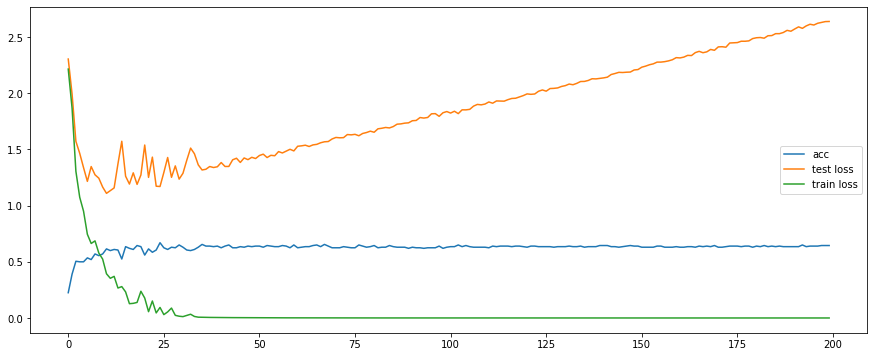

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 6.0)
plt.plot(test_accuracy_history, label='acc') 
plt.plot(test_loss_history, label='test loss');
plt.plot(train_loss_history, label='train loss');
plt.legend(loc='center right');

In [20]:
train_loss_history[-4:] 
# сеть зазубривает тренировочный набор настолько, (train loss стремится к нулю)
# что тестовый лосс линейно уходит в плюс бесконечность.

[tensor(8.0109e-07, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(7.4387e-07, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(7.0572e-07, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(6.0081e-07, device='cuda:0', grad_fn=<NllLossBackward>)]

In [21]:
test_accuracy_history[-4:] # практическая точность на тесте при этом не улучшается.

[tensor(0.6400, device='cuda:0'),
 tensor(0.6450, device='cuda:0'),
 tensor(0.6450, device='cuda:0'),
 tensor(0.6450, device='cuda:0')]

In [22]:
max(test_accuracy_history)

tensor(0.6700, device='cuda:0')

In [23]:
min(test_loss_history)

tensor(1.1096, device='cuda:0', grad_fn=<NllLossBackward>)

In [26]:
test_loss_history[-4:] #6.0081e-07

[tensor(2.6239, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.6317, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.6387, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.6398, device='cuda:0', grad_fn=<NllLossBackward>)]

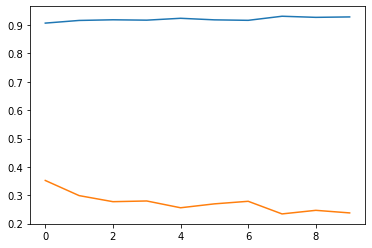

In [16]:
# так выглядел незапорченный процесс обучения. /для сравнения.
#plt.plot(test_accuracy_history)
#plt.plot(test_loss_history); # NO overfit